In [1]:
import os
import sys
import string
import pickle
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from gensim.models import ldamodel, Phrases, phrases
from gensim import corpora
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import TweetTokenizer

%matplotlib inline
pd.set_option('display.max_info_columns',200)
pd.set_option('display.max_colwidth',200)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')

stemmer = SnowballStemmer("english")
tokenizer = TweetTokenizer()

In [2]:
for f in os.listdir('final_output/model_files/'):
        if f.endswith('.gz'):
            tar = tarfile.open('final_output/model_files/' + f, "r:gz")
            tar.extractall(path='final_output/model_files/')
            tar.close()

# load model, corpus, and dictionary objects
fnames = [fn for fn in os.listdir('final_output/model_files/') if '.gensim' in fn]
model = ldamodel.LdaModel.load('final_output/model_files/' + fnames[0])
corpus = corpora.MmCorpus('final_output/model_files/' + 'unigrams_corpus.mm')
dictionary = corpora.Dictionary.load('final_output/model_files/' + 'unigrams_dictionary.pkl')
model.id2word = dictionary
phraser = phrases.Phraser.load('final_output/model_files/document_phraser.pkl')

#cleanup the unzipped files
for f in fnames:
    os.remove('final_output/model_files/' + f)

In [3]:
model, corpus, dictionary, phraser

(<gensim.models.ldamulticore.LdaMulticore at 0x112be49e8>,
 <gensim.models.phrases.Phraser at 0x13f8cb278>)

In [4]:
df = pd.read_csv('final_output/model_files/valence_arousal.csv', header=0, index_col=0, sep=',')
keep = ['Word','V.Mean.Sum','V.SD.Sum', 'A.Mean.Sum','A.SD.Sum']
remove = [col for col in df.columns.tolist() if col not in set(keep)]
df = df.drop(remove, axis=1)
df['word_stemmed'] = df['Word'].apply(stemmer.stem)
df.head()

,Word,V.Mean.Sum,V.SD.Sum,A.Mean.Sum,A.SD.Sum,word_stemmed
1,aardvark,6.26,2.21,2.41,1.40,aardvark
2,abalone,5.30,1.59,2.65,1.90,abalon
3,abandon,2.84,1.54,3.73,2.43,abandon
4,abandonment,2.63,1.74,4.95,2.64,abandon
5,abbey,5.85,1.69,2.20,1.70,abbey


In [5]:
try:
    topics = model.get_topics()
    v_mean = pickle.load(open('final_output/model_files/valence_mean.pkl', 'rb'))
    a_mean = pickle.load(open('final_output/model_files/arousal_mean.pkl', 'rb'))
    v_sd = pickle.load(open('final_output/model_files/valence_sd.pkl', 'rb'))
    a_sd = pickle.load(open('final_output/model_files/arousal_sd.pkl', 'rb'))
except:
    n = len(dictionary.items())
    topics = model.get_topics()
    v_mean = np.zeros(n)
    v_sd = np.zeros(n)
    a_mean = np.zeros(n)
    a_sd = np.zeros(n)
    word_map = {v:k for k,v in dictionary.items()}

    for word in df.word_stemmed.unique():
        if word in set(word_map.keys()):
            if df[df.word_stemmed == word].shape[0] > 1:
                v_mean[word_map[word]] = np.average(df[df.word_stemmed == word]['V.Mean.Sum'])
                a_mean[word_map[word]] = np.average(df[df.word_stemmed == word]['A.Mean.Sum'])
                v_sd[word_map[word]] = np.sqrt(np.average(np.power(df[df.word_stemmed == word]['V.SD.Sum'], 2)))
                a_sd[word_map[word]] = np.sqrt(np.average(np.power(df[df.word_stemmed == word]['A.SD.Sum'], 2)))
            else:
                v_mean[word_map[word]] = df[df.word_stemmed == word]['V.Mean.Sum']
                a_mean[word_map[word]] = df[df.word_stemmed == word]['A.Mean.Sum']
                v_sd[word_map[word]] = df[df.word_stemmed == word]['V.SD.Sum']
                a_sd[word_map[word]] = df[df.word_stemmed == word]['A.SD.Sum']

    pickle.dump(v_mean, open('model_files/valence_mean.pkl', 'wb'))
    pickle.dump(a_mean, open('model_files/arousal_mean.pkl', 'wb'))
    pickle.dump(v_sd, open('model_files/valence_sd.pkl', 'wb'))
    pickle.dump(a_sd, open('model_files/arousal_sd.pkl', 'wb'))

In [6]:
total_v_sd = np.sum(v_sd)
total_a_sd = np.sum(a_sd)

with np.errstate(divide='ignore'):
    v_sd_ratio = total_v_sd / v_sd
    v_sd_ratio[v_sd==0] = 0
    a_sd_ratio = total_a_sd / a_sd
    a_sd_ratio[a_sd==0] = 0
v_sd_weight = v_sd_ratio / np.sum(v_sd_ratio)
a_sd_weight = a_sd_ratio / np.sum(a_sd_ratio)

valence_mat = topics*(v_mean*v_sd_weight)
arousal_mat = topics*(a_mean*a_sd_weight)
topic_valence = np.sum(valence_mat, axis=1)
topic_arousal = np.sum(arousal_mat, axis=1)

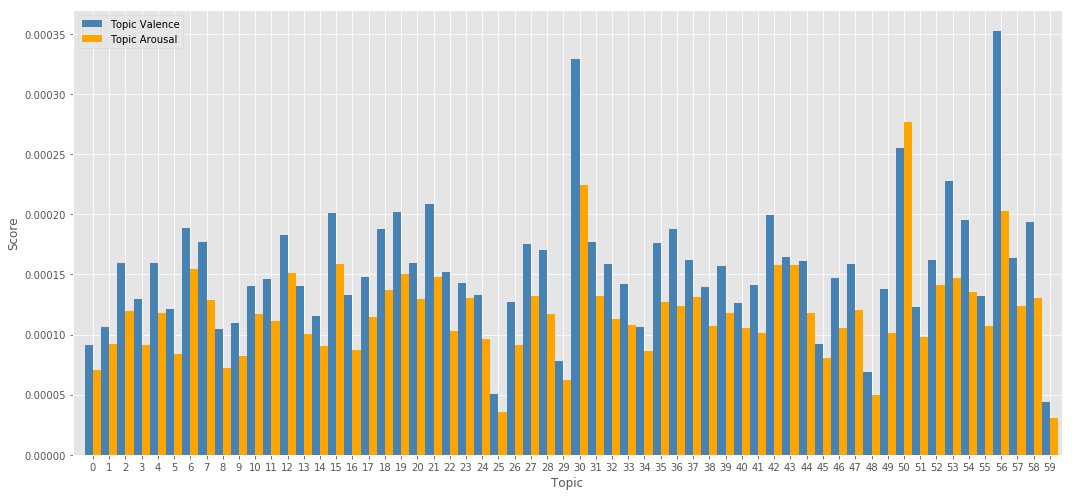

In [7]:
index = np.arange(60)
bar_width = 0.5
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)

rects1 = plt.bar(index, topic_valence, bar_width, color='steelblue', label='Topic Valence')
rects2 = plt.bar(index+bar_width, topic_arousal, bar_width, color='orange', label='Topic Arousal')

plt.xlim(-1,60)
plt.xlabel('Topic')
plt.ylabel('Score')
plt.xticks(index + bar_width / 2, index)
plt.legend()

plt.tight_layout()
plt.show()

In [8]:
topics = model.print_topics(num_topics=60, num_words=30)

In [9]:
topics[25]

(25,
 '0.100*"today" + 0.056*"..._wind" + 0.056*"hydeparkwind_wonderland" + 0.056*"mph_gust" + 0.055*"..._temp" + 0.054*"..._rain" + 0.014*"speed_3.0" + 0.014*"planet" + 0.013*"10" + 0.011*"speed_2.0" + 0.010*"<u+0098>_<u+008d>" + 0.008*"speed_4.0" + 0.007*"22_time" + 0.007*"speed_1.0" + 0.005*"7.0_mph" + 0.005*"8.0_mph" + 0.005*"9.0_mph" + 0.005*"6.0_mph" + 0.005*"whole" + 0.004*"10.0_mph" + 0.004*"wed_gift" + 0.004*"4.0_mph" + 0.004*"speed_0.0" + 0.004*"5.0_mph" + 0.004*"speed_5.0" + 0.003*"thing" + 0.003*"11.0_mph" + 0.003*"agricultur" + 0.003*"cute" + 0.003*"speed_6.0"')

In [10]:
topics[30]

(30,
 '0.025*"marriag" + 0.020*"..." + 0.018*"like" + 0.016*"i\'m" + 0.014*"one" + 0.013*"get" + 0.013*"don\'t" + 0.012*"go" + 0.009*"peopl" + 0.009*"know" + 0.009*"think" + 0.008*"thing" + 0.008*"would" + 0.008*"becaus" + 0.007*"guy" + 0.007*".." + 0.007*"say" + 0.007*"never" + 0.006*"make" + 0.006*"want" + 0.006*"you\'r" + 0.006*"someth" + 0.006*"love" + 0.006*"need" + 0.006*"gun" + 0.005*"see" + 0.005*"someon" + 0.005*"said" + 0.005*"can\'t" + 0.005*"feel"')

In [11]:
topics[56]

(56,
 '0.231*"wed" + 0.019*"video" + 0.019*"beauti" + 0.013*"parti" + 0.012*"..." + 0.009*"#wed" + 0.009*"plan" + 0.008*"love" + 0.007*"like_@youtub" + 0.007*"photo" + 0.007*"night" + 0.006*"fun" + 0.005*"blog" + 0.005*"stun" + 0.004*"friend" + 0.004*"last_night" + 0.004*"look" + 0.004*"day" + 0.004*"style" + 0.003*"sister" + 0.003*"guest" + 0.003*"new" + 0.003*"celebr" + 0.003*"happi" + 0.003*"collect" + 0.003*"great" + 0.003*"david_toni" + 0.003*"wed_planner" + 0.003*"watch" + 0.003*"best"')

In [12]:
topics[50]

(50,
 '0.083*"gun" + 0.013*"kill" + 0.011*"peopl" + 0.010*"ban" + 0.010*"right" + 0.009*"terrorist" + 0.009*"obama" + 0.008*"want" + 0.008*"#gunsens" + 0.008*"law" + 0.007*"#2a" + 0.007*"american" + 0.007*"america" + 0.006*"gun_control" + 0.006*"..." + 0.006*"us" + 0.006*"use" + 0.006*"get" + 0.006*"@nra" + 0.006*"protect" + 0.006*"muslim" + 0.005*"need" + 0.005*"shoot" + 0.005*"onli" + 0.005*"nra" + 0.005*"stop" + 0.005*"say" + 0.005*"don\'t" + 0.005*"like" + 0.004*"take"')

In [13]:
topics[6]

(6,
 '0.130*"chang" + 0.015*"tackl_climat" + 0.015*"gun_control" + 0.013*"mind" + 0.012*"insan" + 0.012*"combat_climat" + 0.010*"kurt_russel" + 0.010*"date" + 0.010*"question" + 0.009*"climat_chang" + 0.009*"..." + 0.007*"via_@breitbartnew" + 0.007*"effort" + 0.007*"promis" + 0.006*"keyston_xl" + 0.006*"breitbart" + 0.006*"cake" + 0.005*"think" + 0.005*"voter" + 0.005*"san_bernardino" + 0.005*"absolut_insan" + 0.005*"blast" + 0.004*"hide" + 0.004*"@reuter" + 0.003*"pls_rt" + 0.003*"report" + 0.003*"call" + 0.003*"yet_anoth" + 0.003*"@benshapiro" + 0.003*"@drudge_report"')

In [14]:
topics[42]

(42,
 '0.028*"god" + 0.023*"climat_chang" + 0.016*"..." + 0.012*"marriag" + 0.010*"design" + 0.010*"expert" + 0.010*"fake" + 0.009*"gun" + 0.009*"except" + 0.008*"univers" + 0.008*"dream" + 0.007*"ridicul" + 0.006*"gone" + 0.006*"negoti" + 0.006*"whether" + 0.006*"nov" + 0.006*"gain" + 0.005*"us" + 0.005*"y\'all" + 0.005*"90" + 0.004*"harm" + 0.004*"remov" + 0.004*"@guardian" + 0.004*"convinc" + 0.004*"immedi" + 0.004*"jesus" + 0.004*"best_way" + 0.004*"option" + 0.003*"say" + 0.003*"howev"')

In [15]:
topics[43]

(43,
 '0.044*"gun" + 0.015*"allow" + 0.012*"texa" + 0.009*"peac" + 0.009*"drop" + 0.008*"scandal" + 0.007*"climat_chang" + 0.007*"arm_dealer" + 0.007*"good_guy" + 0.007*"climatechang" + 0.007*"link_pari" + 0.006*"common_sens" + 0.006*"attack_trace" + 0.006*"..." + 0.006*"street" + 0.006*"implic_iran-contra" + 0.006*"legisl" + 0.006*"back_florida" + 0.005*"shoot" + 0.005*"facebook" + 0.005*"bodi" + 0.004*"regist" + 0.004*"load" + 0.004*"space" + 0.004*"magic" + 0.004*"crop" + 0.004*"#texa" + 0.004*"blue" + 0.004*"drone" + 0.004*"lower"')

In [16]:
topics[59]

(59,
 '0.339*"<f0>_<u+009f>" + 0.015*"<u+0098>" + 0.013*"..." + 0.010*"<u+0093>_<u+00b7>" + 0.008*"<u+0091>_<u+00b0>" + 0.007*"<u+008f>_<u+00bc>" + 0.007*"#climat_#chang" + 0.007*"<u+008f>_<u+00bb>" + 0.006*"<u+0092>_<u+008d>" + 0.005*"<u+0091>_<u+0089>" + 0.005*"<u+0091>_<u+008f>" + 0.005*"<u+0091>_<u+008d>" + 0.005*"tell_world" + 0.005*"<u+008c>_<u+008f>" + 0.005*"<u+0098>_<u+008a>" + 0.004*"<u+0087>_<u+00ba>" + 0.004*"<u+0087>_<u+00b8>" + 0.004*"<u+0091>" + 0.004*"<u+008f>_<u+00bd>" + 0.004*"<u+2764>_<u+fe0f>" + 0.004*"<u+0099>_<u+008c>" + 0.003*"<u+0094>_<u+00ab>" + 0.003*"<u+0099>_<u+008f>" + 0.003*"<u+0098>_<u+00a9>" + 0.003*"<u+0098>_<u+0081>" + 0.003*"climat_chang" + 0.003*"<u+0092>" + 0.003*"<u+009f>_<u+0091>" + 0.003*"<u+008f>" + 0.003*"<u+00a4>_<u+0094>"')

In [17]:
# SCALE TO A 0-1 RANGE

# X_std = (X - X.min(axis=0)) / (X.max(axis=0) - X.min(axis=0))
# X_scaled = X_std * (max - min) + min
try:
    v_scaled = pickle.load(open('final_output/model_files/topic_valence_scaled.pkl', 'rb'))
    a_scaled = pickle.load(open('final_output/model_files/topic_arousal_scaled.pkl', 'rb'))
except:
    v_min = np.min(topic_valence)
    v_max = np.max(topic_valence)
    a_min = np.min(topic_arousal)
    a_max = np.max(topic_arousal)

    v_std = ((topic_valence - v_min) / (v_max - v_min))
    v_scaled  = v_std * (1 - 0) + 0

    a_std = ((topic_arousal - a_min) / (a_max - a_min))
    a_scaled  = a_std * (1 - 0) + 0

    pickle.dump(v_scaled, open('model_files/topic_valence_scaled.pkl', 'wb'))
    pickle.dump(a_scaled, open('model_files/topic_arousal_scaled.pkl', 'wb'))

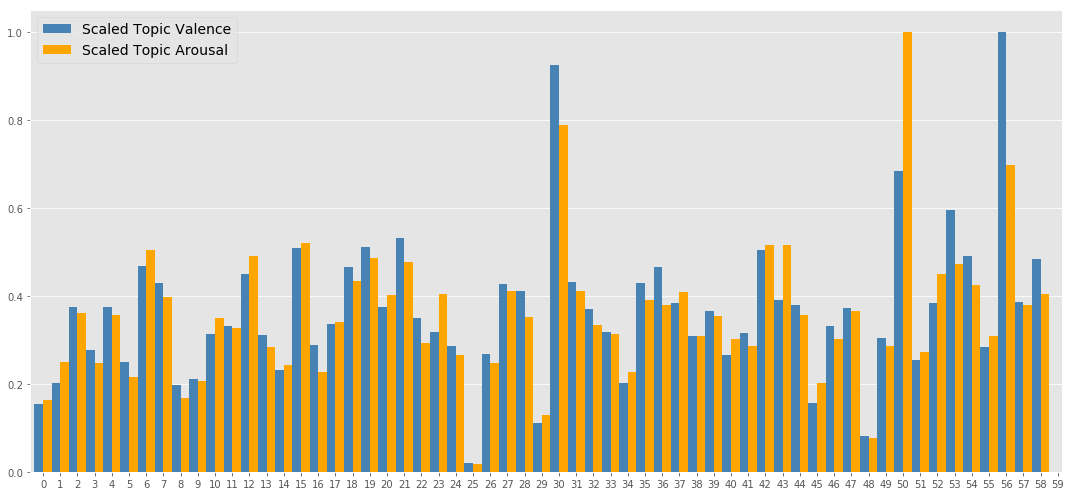

In [21]:
index = np.arange(60)
bar_width = 0.5
fig = plt.figure(figsize=(15,7))
ax = fig.add_subplot(111)
ax.grid(axis='x')

rects1 = plt.bar(index, v_scaled, bar_width, color='steelblue', label='Scaled Topic Valence')
rects2 = plt.bar(index+bar_width, a_scaled, bar_width, color='orange', label='Scaled Topic Arousal')

plt.xlim(-0.5,59.5)
plt.ylim(0,1.05)
#plt.xlabel('Topic', fontsize=18)
#plt.ylabel('Score')
plt.xticks(index + bar_width / 2, index)
plt.legend(fontsize=14)

plt.tight_layout()
plt.savefig('plots/scaled_topic_val_ar.png', dpi=300)
plt.show()